Dataset view (first 5 rows)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-11-13,29.689144,29.907957,29.689144,29.718983,8.949275,1573674.0
1,2000-11-14,29.639414,29.699089,29.539951,29.669250,8.934299,1691576.0
2,2000-11-15,29.665274,29.798552,29.539951,29.679197,8.937295,2381115.0
3,2000-11-16,29.593660,29.768713,29.490221,29.639414,8.925314,985859.0
4,2000-11-17,29.619520,30.186449,29.559843,30.017365,9.039127,1459827.0


Dataset dimensions: 5851 x 7

Dataset info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5851 entries, 0 to 5850
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5851 non-null   object 
 1   Open       5849 non-null   float64
 2   High       5849 non-null   float64
 3   Low        5849 non-null   float64
 4   Close      5849 non-null   float64
 5   Adj Close  5849 non-null   float64
 6   Volume     5849 non-null   float64
dtypes: float64(6), object(1)
memory usage: 320.1+ KB

Dataset description



,Date,Open,High,Low,Close,Adj Close,Volume
count,5851,5849.000000,5849.000000,5849.000000,5849.000000,5849.000000,5.849000e+03
unique,5850,NaN,NaN,NaN,NaN,NaN,NaN
top,2023-11-10,NaN,NaN,NaN,NaN,NaN,NaN
freq,2,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,60.377884,60.795727,59.925994,60.372897,40.428977,3.461308e+06
std,NaN,23.412872,23.538044,23.264352,23.407636,27.457296,2.259009e+06
min,NaN,23.323631,23.462877,22.925789,23.074980,7.835657,0.000000e+00
25%,NaN,38.789837,39.187679,38.481506,38.849514,16.915661,2.149121e+06
50%,NaN,56.285046,56.643108,55.976719,56.294994,28.751549,2.881474e+06
75%,NaN,79.000000,79.480003,78.500000,79.040001,58.790016,4.059600e+06


 Number of NaN entries: 12
 Number of duplicated entries: 0


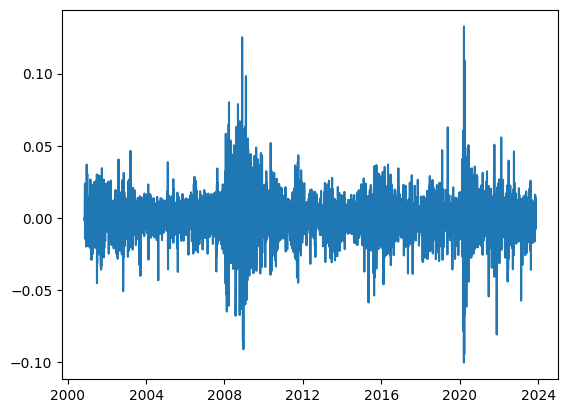


train_feature.shape=(4676, 1), test_feature.shape=(1170, 1) 
train_target.shape=(4676, 1), test_target.shape=(1170, 1)


X_train.shape=(4646, 30, 1), y_train.shape=(4646, 1) 
X_test.shape=(1140, 30, 1), y_test.shape=(1140, 1)



In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from tabulate import tabulate

from keras import optimizers
from keras.callbacks import History
from keras.models import Model,Sequential
from keras.losses import Huber
from keras.metrics import RootMeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError
from keras.layers import SimpleRNN, Dense, Dropout, LSTM, GRU
# Load your dataset

def describe_dataset(dataset:pd.DataFrame):
    _data = dataset
    print("Dataset view (first 5 rows)")
    display(_data.head())
    print(f"Dataset dimensions: {_data.shape[0]} x {_data.shape[1]}\n")
    print("Dataset info\n")
    _data.info()
    print("\nDataset description\n")
    display(_data.describe(include='all'))
    print(f" Number of NaN entries: {sum(_data.isna().sum())}")
    print(f" Number of duplicated entries: {_data.duplicated().sum()}")
    return _data


df = pd.read_csv('CBA.AX.csv')
describe_dataset(df)
# Let's assume 'Close' is your target column
# Calculate the rate of return
df['Return'] = df['Close'].pct_change()

#converting dates to type datetime from object
def string_to_datetime(finance_date):
    year, month, day = finance_date.split('-')
    return datetime(year = int(year), month= int(month), day= int(day))

df["Date"] = df["Date"].apply(string_to_datetime)
#replacing index with Date so that RNN understands sequential nature of data
df.index = df.pop('Date')
df = df.loc[df['High']>df['Adj Close']]
# Drop the NaN values
df = df.dropna()

plt.plot(df.index,df['Return'])
plt.show()

# Normalize the 'Return' column
scaler_X = MinMaxScaler(feature_range=(0,1))
scaler_y = MinMaxScaler(feature_range=(0,1))


feature = df['Open']
target = df['Return']

# Split the dataset into train and test sets
train_size = int(len(feature) * 0.8)
train_feature, test_feature = feature.iloc[:train_size].values.reshape(-1,1), feature.iloc[train_size:].values.reshape(-1,1)
train_target, test_target = target.iloc[:train_size].values.reshape(-1,1), target.iloc[train_size:].values.reshape(-1,1)


print(f"\n{train_feature.shape=}, {test_feature.shape=} \n{train_target.shape=}, {test_target.shape=}\n")


train_feature = scaler_X.fit_transform(train_feature)
test_feature = scaler_X.transform(test_feature)

train_target = scaler_y.fit_transform(train_target)
test_target = scaler_y.transform(test_target)

# Convert an array of values into a dataset matrix
def create_sequences(Xsc,ysc, look_back):
    X,y =[],[]
    for i in range(Xsc.shape[0]-look_back):
        X.append(Xsc[i:i+look_back,:])

        y.append(ysc[i+look_back,:])

    return np.array(X),np.array(y)

# Reshape into sequences into sizes of 30
look_back = 30
X_train, y_train = create_sequences(train_feature, train_target, look_back)
X_test, y_test = create_sequences(test_feature, test_target, look_back)

print(f"\n{X_train.shape=}, {y_train.shape=} \n{X_test.shape=}, {y_test.shape=}\n")


def train(model,X_train,y_train,X_test,y_test,epochs,batch_size,shuffle,validation_split):
    print(model.summary())
    _model = model.fit(X_train,y_train,epochs=epochs,batch_size=batch_size,shuffle=shuffle,validation_split=validation_split)
    plot_loss(_model)
    predictions = model.predict(X_test)
    plot_residual(y_test,predictions)
    table = [[f'Training {model.loss} Loss',f'Validation {model.loss} Loss','Training RMSE'	,'Training MAE',	'Training MAPE','Validation RMSE'	,'Validation MAE',	'Validation MAPE'],
         [_model.history['loss'][-1],_model.history['val_loss'][-1] ,_model.history['root_mean_squared_error'][-1], _model.history['mean_absolute_error'][-1], _model.history['mean_absolute_percentage_error'][-1],_model.history['val_root_mean_squared_error'][-1] ,_model.history['val_mean_absolute_error'][-1] ,_model.history['val_mean_absolute_percentage_error'][-1] ]]
    print("\n",tabulate(table,headers='firstrow'),"\n\n")
    return _model, predictions#, predicted_prices

def plot_loss(model):
    plt.plot(model.history['loss'])
    plt.plot(model.history['val_loss'])
    plt.title('Model Training & Validation Loss')
    plt.legend(['training loss','validation loss',])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

def reconstruct_original_shape(X_sequences, original_shape):
    reconstructed_X = []
    for sequence in X_sequences:
        for i in range(sequence.shape[0]):
            reconstructed_X.append(sequence[i, :])

    return np.array(reconstructed_X)[:original_shape[0], :]


def plot_residual(y_test,predictions):
    fig, axs = plt.subplots(1,2,figsize=(12,5))
    plt.figure(dpi=80, facecolor='w', edgecolor='k')
    residual = scaler_y.inverse_transform(y_test)-scaler_y.inverse_transform(predictions)
    _predicted = scaler_y.inverse_transform(predictions)
    axs[0].scatter(_predicted,residual, color='blue', marker='o',label='Fitted values')
    axs[0].axhline(y=0, color='red', linestyle='--', linewidth=2, label='Residuals')
    axs[0].set_title('Residual plot')
    axs[1].hist(residual, linewidth=1,bins=20, edgecolor='black')
    axs[1].set_title('Histogram plot of residual')
    axs[0].legend()
    axs[1].legend()
    plt.show()

# RNN

### Mean Absolute Error

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10)                120       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 131 (524.00 Byte)
Trainable params: 131 (524.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
131/131 [==============================] - 3s 9ms/step - loss: 0.1385 - root_mean_squared_error: 0.2452 - mean_absolute_error: 0.1385 - mean_absolute_percentage_error: 114071.5312 - val_loss: 0.0379 - val_root_mean_squared_error: 0.0497 - val_mean_absolute_error: 0.0379 - val_mean_absolute_percentage_error: 9.3126
Epoch 2/25
131/131 [==============================] - 1s 7ms/step - loss: 0.0479 -

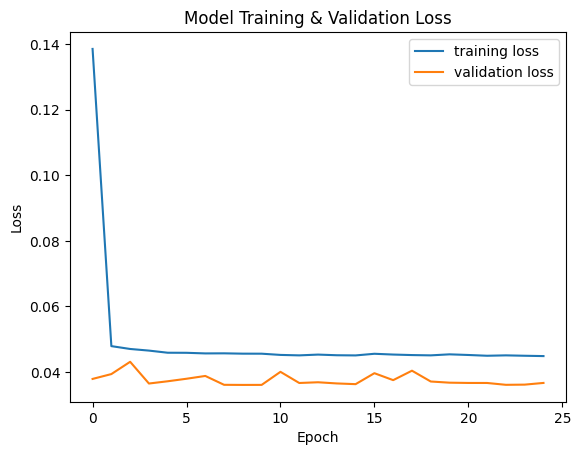

36/36 [==============================] - 0s 3ms/step


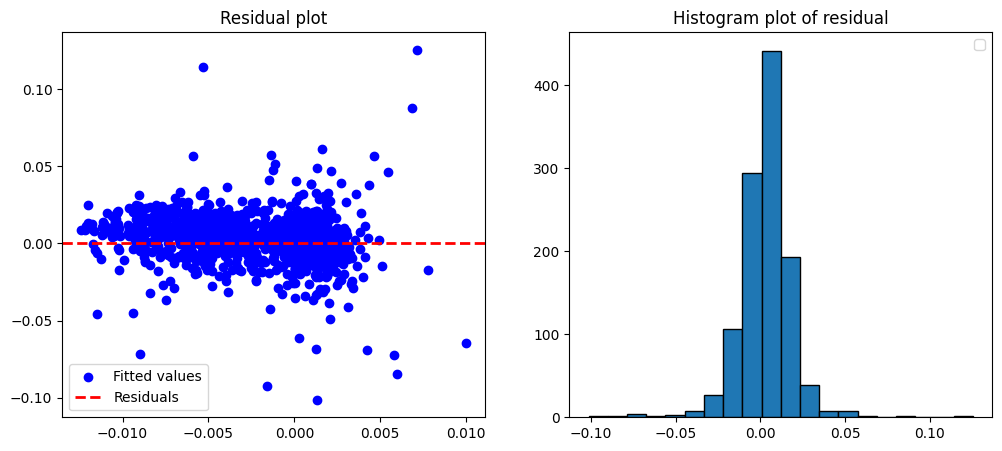

<Figure size 512x384 with 0 Axes>


   Training mean_absolute_error Loss    Validation mean_absolute_error Loss    Training RMSE    Training MAE    Training MAPE    Validation RMSE    Validation MAE    Validation MAPE
-----------------------------------  -------------------------------------  ---------------  --------------  ---------------  -----------------  ----------------  -----------------
                          0.0448811                              0.0366994        0.0645175       0.0448811           102156          0.0484715         0.0366994            9.20977 




In [3]:
model_simple_rnn1 = Sequential()
model_simple_rnn1.add(SimpleRNN(10, activation='tanh',input_shape=(look_back, 1)))
model_simple_rnn1.add(Dense(1,activation='tanh'))

# Compile the model
model_simple_rnn1.compile(optimizer='adam', loss='mean_absolute_error', metrics=[RootMeanSquaredError(),MeanAbsoluteError(),MeanAbsolutePercentageError()])


# Train the model
# model_simple_rnn.fit(X_train, y_train, epochs=10, batch_size=32, shuffle=True, validation_split = 0.1)

rnn1_stats, rnn1_predictions= train(model=model_simple_rnn1,
                                    X_train=X_train,
                                    y_train=y_train,
                                    X_test=X_test,
                                    y_test=y_test,
                                    epochs=25,
                                    batch_size=32,
                                    shuffle=True,
                                    validation_split = 0.1)


### Mean Absolute Percentage Error

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 50)                2600      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2651 (10.36 KB)
Trainable params: 2651 (10.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
131/131 [==============================] - 2s 10ms/step - loss: 95535.3281 - root_mean_squared_error: 0.4730 - mean_absolute_error: 0.3695 - mean_absolute_percentage_error: 95535.3281 - val_loss: 172.4506 - val_root_mean_squared_error: 0.7220 - val_mean_absolute_error: 0.7203 - val_mean_absolute_percentage_error: 172.4506
Epoch 2/25
131/131 [==============================] - 1s 7ms/step - loss: 51

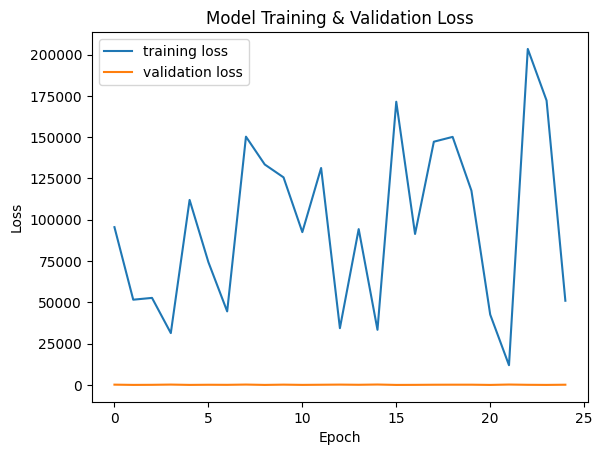

36/36 [==============================] - 0s 3ms/step


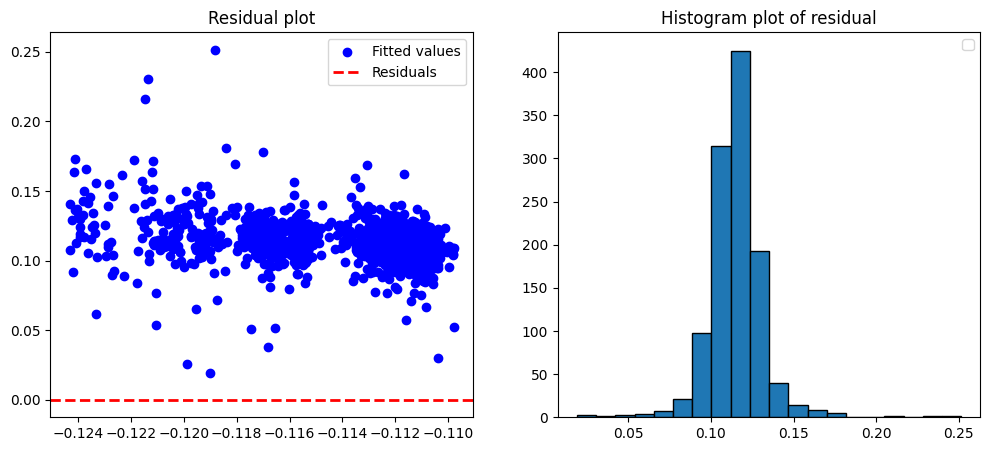

<Figure size 512x384 with 0 Axes>


   Training mean_absolute_percentage_error Loss    Validation mean_absolute_percentage_error Loss    Training RMSE    Training MAE    Training MAPE    Validation RMSE    Validation MAE    Validation MAPE
----------------------------------------------  ------------------------------------------------  ---------------  --------------  ---------------  -----------------  ----------------  -----------------
                                       50972.3                                           130.551         0.457759        0.376127          50972.3            0.54887          0.546706            130.551 




In [4]:
model_simple_rnn2 = Sequential()
model_simple_rnn2.add(SimpleRNN(50, activation='tanh', input_shape=(look_back, 1)))
model_simple_rnn2.add(Dense(1, activation='tanh'))

# Compile the model
model_simple_rnn2.compile(optimizer='adam', loss='mean_absolute_percentage_error', metrics=[RootMeanSquaredError(),MeanAbsoluteError(),MeanAbsolutePercentageError()])

# Train the model
# model_simple_rnn.fit(X_train, y_train, epochs=10, batch_size=32, shuffle=True, validation_split = 0.1)

rnn2_stats, rnn2_predictions= train(model=model_simple_rnn2,
                                    X_train=X_train,
                                    y_train=y_train,
                                    X_test=X_test,
                                    y_test=y_test,
                                    epochs=25,
                                    batch_size=32,
                                    shuffle=True,
                                    validation_split = 0.1)

### Huber

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 50)                2600      
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2651 (10.36 KB)
Trainable params: 2651 (10.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
131/131 [==============================] - 2s 10ms/step - loss: 0.0055 - root_mean_squared_error: 0.1046 - mean_absolute_error: 0.0655 - mean_absolute_percentage_error: 94553.3984 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0482 - val_mean_absolute_error: 0.0367 - val_mean_absolute_percentage_error: 8.9715
Epoch 2/25
131/131 [==============================] - 1s 8ms/step - loss: 0.0022 - r

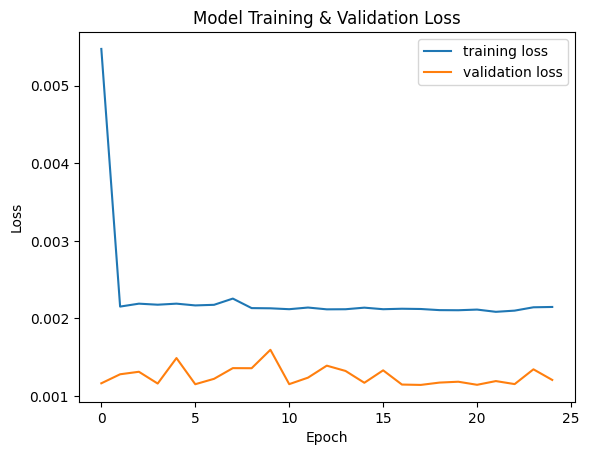

36/36 [==============================] - 0s 3ms/step


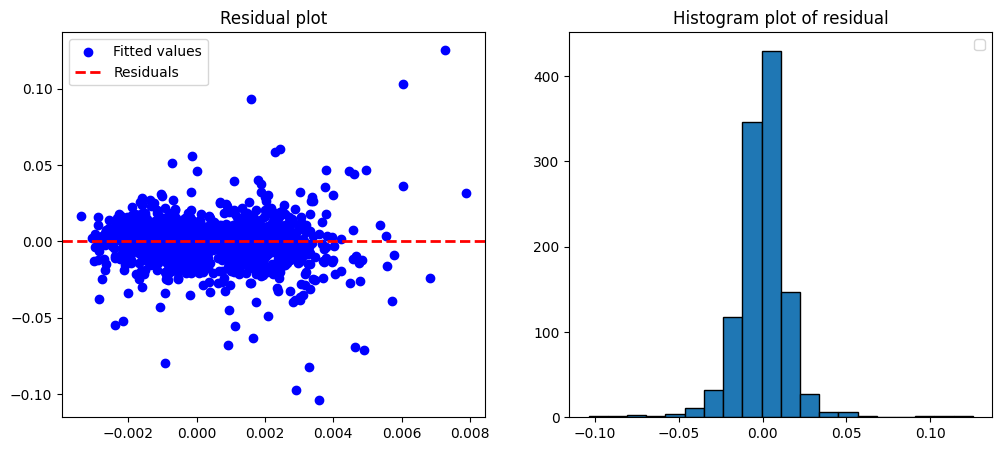

<Figure size 512x384 with 0 Axes>


   Training <keras.src.losses.Huber object at 0x7cdf3eca14e0> Loss    Validation <keras.src.losses.Huber object at 0x7cdf3eca14e0> Loss    Training RMSE    Training MAE    Training MAPE    Validation RMSE    Validation MAE    Validation MAPE
-----------------------------------------------------------------  -------------------------------------------------------------------  ---------------  --------------  ---------------  -----------------  ----------------  -----------------
                                                       0.00214784                                                            0.0012069        0.0655414       0.0459512           101095          0.0491305         0.0372865            9.43535 




In [5]:
model_simple_rnn3 = Sequential()
model_simple_rnn3.add(SimpleRNN(50, activation='tanh',input_shape=(look_back, 1)))
model_simple_rnn3.add(Dense(1, activation='tanh'))

# Compile the model
model_simple_rnn3.compile(optimizer='adam', loss=Huber(delta=1.0), metrics=[RootMeanSquaredError(),MeanAbsoluteError(),MeanAbsolutePercentageError()])

# Train the model
rnn3_stats, rnn3_predictions= train(model=model_simple_rnn3,
                                    X_train=X_train,
                                    y_train=y_train,
                                    X_test=X_test,
                                    y_test=y_test,
                                    epochs=25,
                                    batch_size=32,
                                    shuffle=True,
                                    validation_split = 0.1)

# RNN with Dropout

### Mean Absolute Error

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 10)                120       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 131 (524.00 Byte)
Trainable params: 131 (524.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
131/131 [==============================] - 3s 11ms/step - loss: 0.1178 - root_mean_squared_error: 0.1544 - mean_absolute_error: 0.1178 - mean_absolute_percentage_error: 2241.7358 - val_loss: 0.0411 - val_root_mean_squared_error: 0.0535 - val_mean_absolute_error: 0

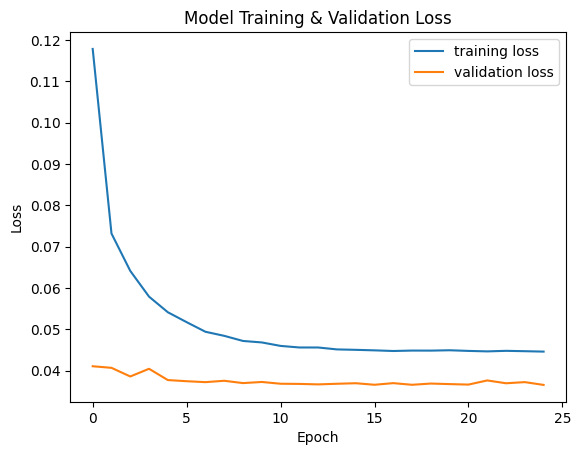

36/36 [==============================] - 0s 3ms/step


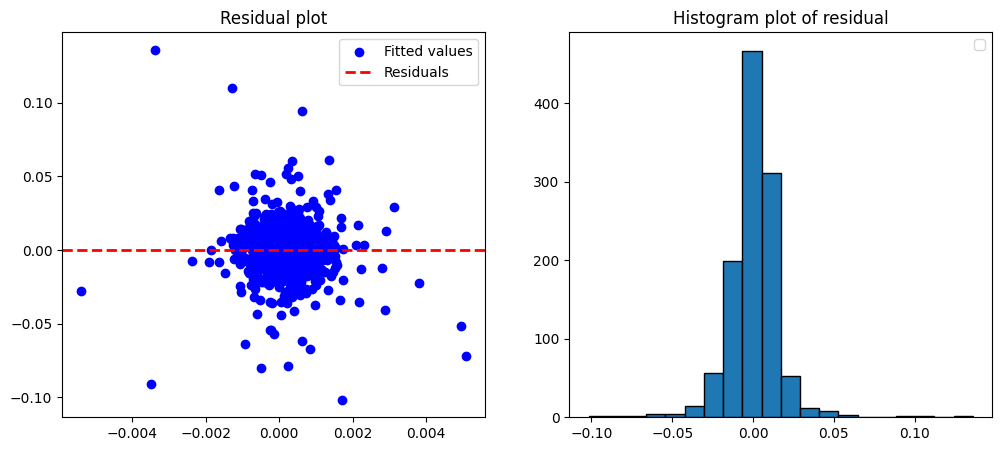

<Figure size 512x384 with 0 Axes>


   Training mean_absolute_error Loss    Validation mean_absolute_error Loss    Training RMSE    Training MAE    Training MAPE    Validation RMSE    Validation MAE    Validation MAPE
-----------------------------------  -------------------------------------  ---------------  --------------  ---------------  -----------------  ----------------  -----------------
                          0.0445992                               0.036538        0.0642409       0.0445992           100216          0.0480899          0.036538            9.07068 




In [6]:
model_simple_rnn_with_dropout1 = Sequential()
model_simple_rnn_with_dropout1.add(SimpleRNN(10, activation='tanh', input_shape=(look_back, 1)))
model_simple_rnn_with_dropout1.add(Dropout(0.2))
model_simple_rnn_with_dropout1.add(Dense(1, activation='tanh'))


model_simple_rnn_with_dropout1.compile(optimizer='adam', loss='mean_absolute_error', metrics=[RootMeanSquaredError(), MeanAbsoluteError(), MeanAbsolutePercentageError()])

# Train the model
rnn_with_dropout_stats1, rnn_with_dropout_predictions1 = train(model=model_simple_rnn_with_dropout1,
                                                            X_train=X_train,
                                                            y_train=y_train,
                                                            X_test=X_test,
                                                            y_test=y_test,
                                                            epochs=25,
                                                            batch_size=32,
                                                            shuffle=True,
                                                            validation_split=0.1)

### Mean Absolute Percentage Error

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 10)                120       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 131 (524.00 Byte)
Trainable params: 131 (524.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
131/131 [==============================] - 3s 10ms/step - loss: 129884.8047 - root_mean_squared_error: 0.2125 - mean_absolute_error: 0.1629 - mean_absolute_percentage_error: 129884.8047 - val_loss: 20.2930 - val_root_mean_squared_error: 0.0999 - val_mean_absolute_

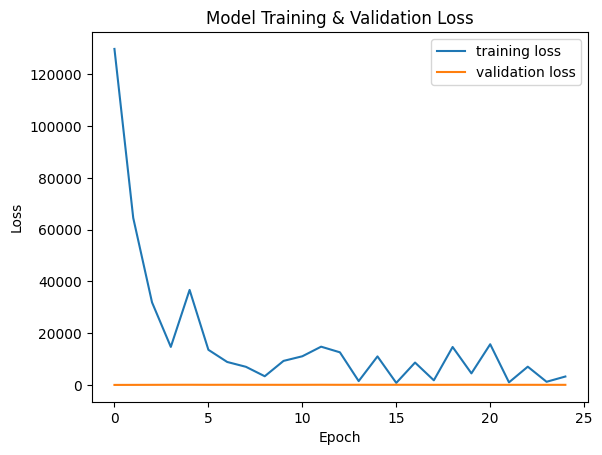

36/36 [==============================] - 0s 3ms/step


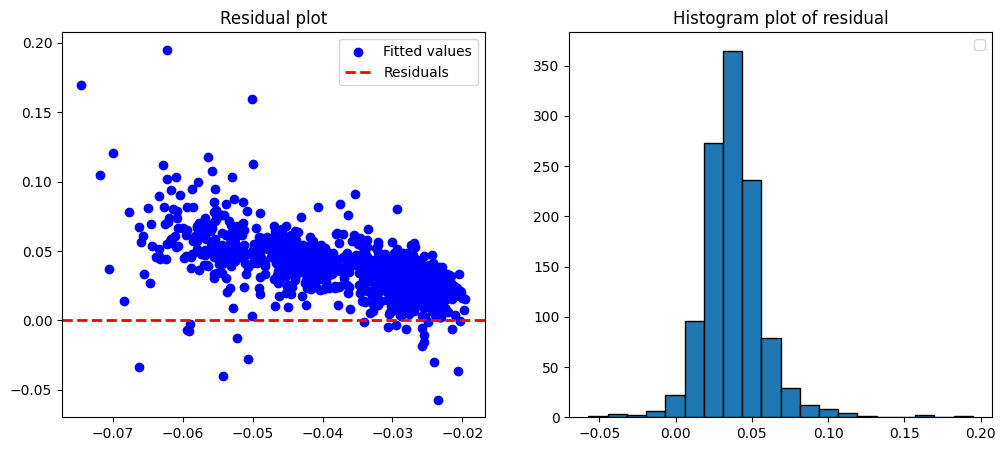

<Figure size 512x384 with 0 Axes>


   Training mean_absolute_percentage_error Loss    Validation mean_absolute_percentage_error Loss    Training RMSE    Training MAE    Training MAPE    Validation RMSE    Validation MAE    Validation MAPE
----------------------------------------------  ------------------------------------------------  ---------------  --------------  ---------------  -----------------  ----------------  -----------------
                                       3267.95                                           54.2081         0.335273        0.319162          3267.95           0.236418          0.230489            54.2081 




In [7]:
model_simple_rnn_with_dropout2 = Sequential()
model_simple_rnn_with_dropout2.add(SimpleRNN(10, activation='tanh', input_shape=(look_back, 1)))
model_simple_rnn_with_dropout2.add(Dropout(0.2))
model_simple_rnn_with_dropout2.add(Dense(1, activation='tanh'))


model_simple_rnn_with_dropout2.compile(optimizer='adam', loss='mean_absolute_percentage_error', metrics=[RootMeanSquaredError(), MeanAbsoluteError(), MeanAbsolutePercentageError()])

# Train the model
rnn_with_dropout_stats2, rnn_with_dropout_predictions2 = train(model=model_simple_rnn_with_dropout2,
                                                            X_train=X_train,
                                                            y_train=y_train,
                                                            X_test=X_test,
                                                            y_test=y_test,
                                                            epochs=25,
                                                            batch_size=32,
                                                            shuffle=True,
                                                            validation_split=0.1)

### Huber

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_5 (SimpleRNN)    (None, 10)                120       
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 131 (524.00 Byte)
Trainable params: 131 (524.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
131/131 [==============================] - 3s 14ms/step - loss: 0.0352 - root_mean_squared_error: 0.2656 - mean_absolute_error: 0.1921 - mean_absolute_percentage_error: 128696.5625 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0544 - val_mean_absolute_error:

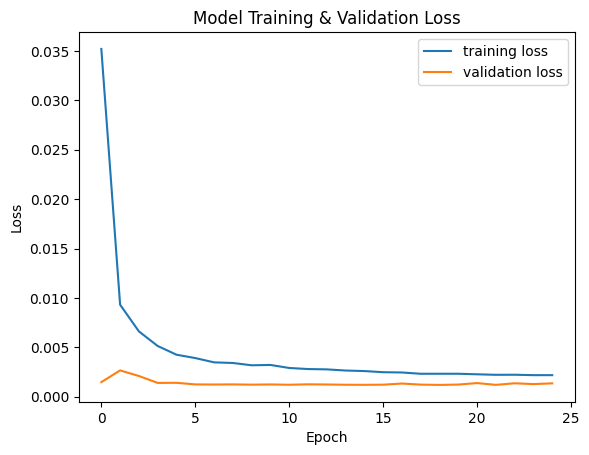

36/36 [==============================] - 0s 3ms/step


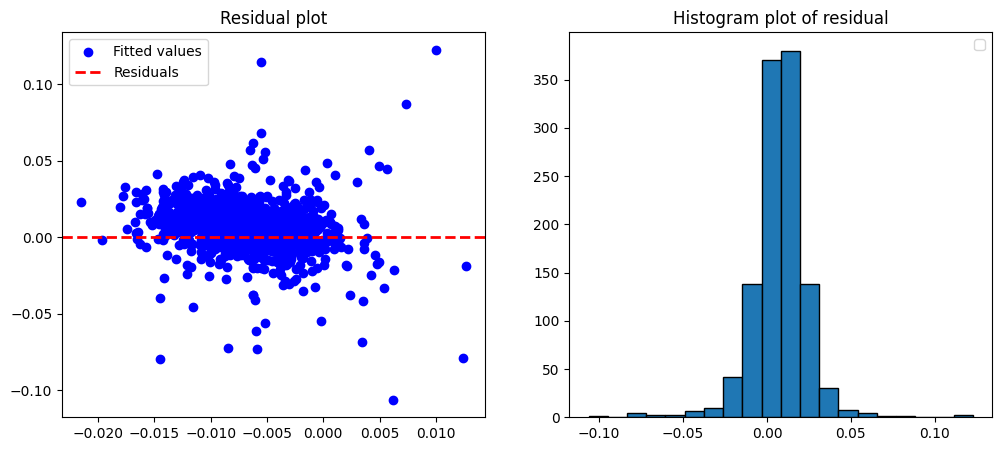

<Figure size 512x384 with 0 Axes>


   Training <keras.src.losses.Huber object at 0x7cdf3e8a4340> Loss    Validation <keras.src.losses.Huber object at 0x7cdf3e8a4340> Loss    Training RMSE    Training MAE    Training MAPE    Validation RMSE    Validation MAE    Validation MAPE
-----------------------------------------------------------------  -------------------------------------------------------------------  ---------------  --------------  ---------------  -----------------  ----------------  -----------------
                                                       0.00218339                                                           0.00135501        0.0660817       0.0467855          95905.9          0.0520579         0.0401715            9.49087 




In [8]:
model_simple_rnn_with_dropout3 = Sequential()
model_simple_rnn_with_dropout3.add(SimpleRNN(10, activation='tanh', input_shape=(look_back, 1)))
model_simple_rnn_with_dropout3.add(Dropout(0.2))
model_simple_rnn_with_dropout3.add(Dense(1, activation='tanh'))


model_simple_rnn_with_dropout3.compile(optimizer='adam', loss=Huber(delta=1.0), metrics=[RootMeanSquaredError(), MeanAbsoluteError(), MeanAbsolutePercentageError()])

# Train the model
rnn_with_dropout_stats3, rnn_with_dropout_predictions3 = train(model=model_simple_rnn_with_dropout3,
                                                            X_train=X_train,
                                                            y_train=y_train,
                                                            X_test=X_test,
                                                            y_test=y_test,
                                                            epochs=25,
                                                            batch_size=32,
                                                            shuffle=True,
                                                            validation_split=0.1)

# LTSM

### Mean Absolute Error

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
131/131 [==============================] - 6s 23ms/step - loss: 0.0868 - root_mean_squared_error: 0.1329 - mean_absolute_error: 0.0868 - mean_absolute_percentage_error: 92663.2734 - val_loss: 0.0389 - val_root_mean_squared_error: 0.0504 - val_mean_absolute_error: 0.0389 - val_mean_absolute_percentage_error: 9.2497
Epoch 2/25
131/131 [==============================] - 2s 16ms/step - loss: 0.0452 

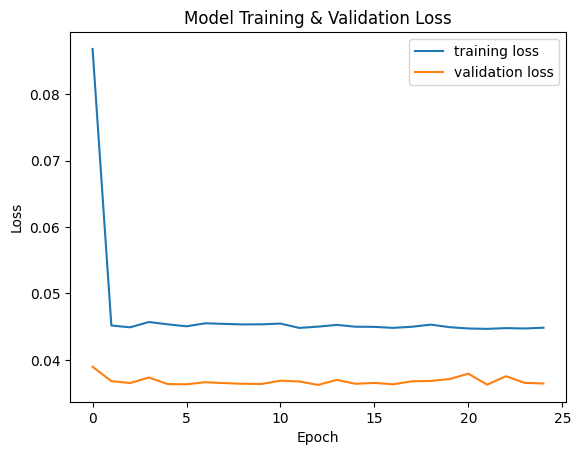

36/36 [==============================] - 1s 6ms/step


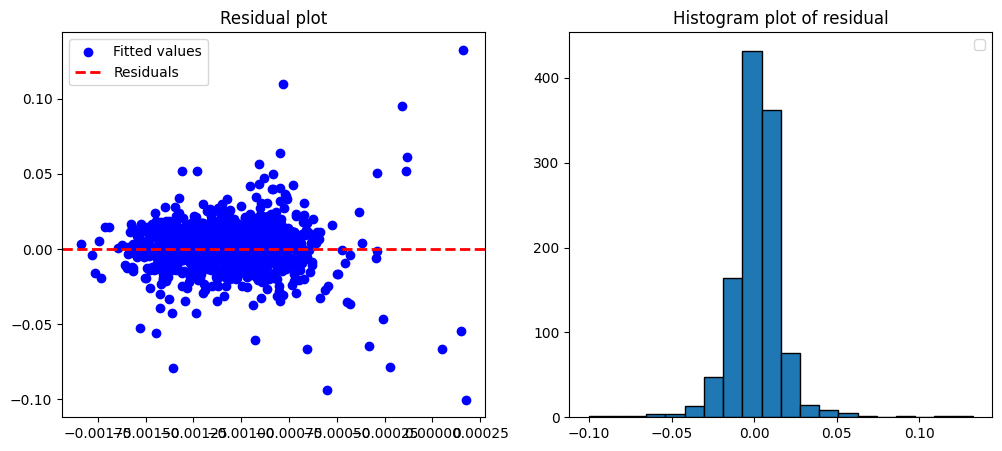

<Figure size 512x384 with 0 Axes>


   Training mean_absolute_error Loss    Validation mean_absolute_error Loss    Training RMSE    Training MAE    Training MAPE    Validation RMSE    Validation MAE    Validation MAPE
-----------------------------------  -------------------------------------  ---------------  --------------  ---------------  -----------------  ----------------  -----------------
                          0.0448327                              0.0364312        0.0643079       0.0448327           101833          0.0479708         0.0364312            8.91639 




In [9]:
model_lstm1 = Sequential()
model_lstm1.add(LSTM(50, activation='tanh',input_shape=(look_back, 1)))
model_lstm1.add(Dense(1,activation='tanh'))

# Compile the model
model_lstm1.compile(optimizer='adam', loss='mean_absolute_error', metrics=[RootMeanSquaredError(),MeanAbsoluteError(),MeanAbsolutePercentageError()])

# Train the model

lstm1_stats, lstm1_predictions= train(model=model_lstm1,
                                    X_train=X_train,
                                    y_train=y_train,
                                    X_test=X_test,
                                    y_test=y_test,
                                    epochs=25,
                                    batch_size=32,
                                    shuffle=True,
                                    validation_split = 0.1)

### Mean Absolute Percentage Error

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                10400     
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
131/131 [==============================] - 7s 21ms/step - loss: 95110.9219 - root_mean_squared_error: 0.2281 - mean_absolute_error: 0.1995 - mean_absolute_percentage_error: 95110.9219 - val_loss: 64.7667 - val_root_mean_squared_error: 0.2782 - val_mean_absolute_error: 0.2741 - val_mean_absolute_percentage_error: 64.7667
Epoch 2/25
131/131 [==============================] - 2s 17ms/step - loss: 3

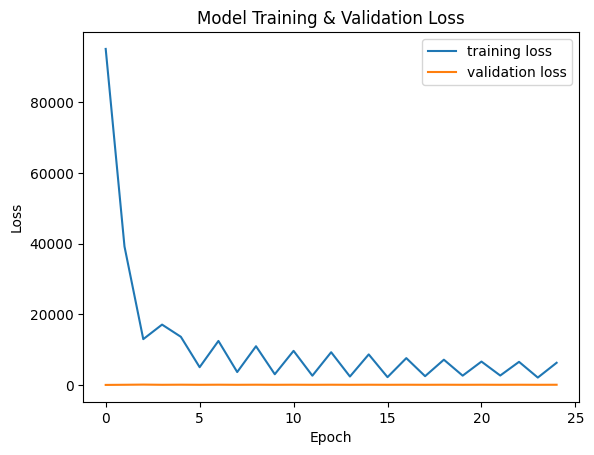

36/36 [==============================] - 1s 9ms/step


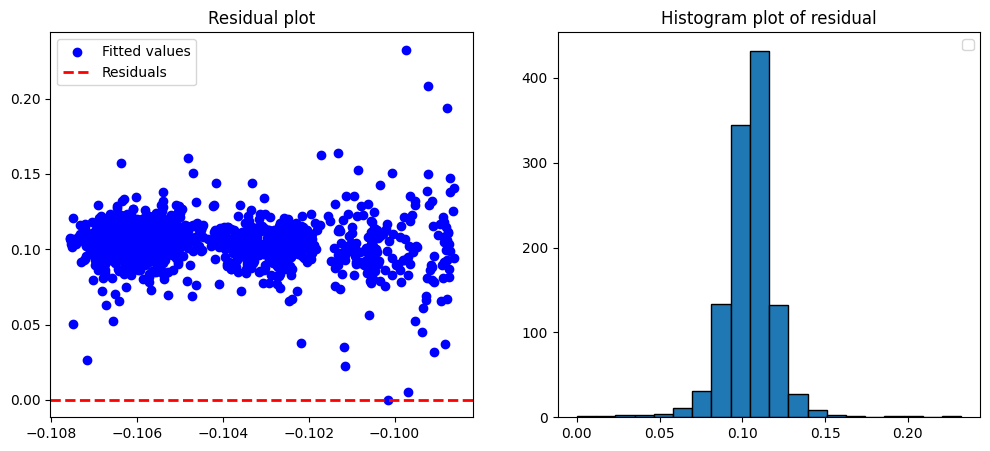

<Figure size 512x384 with 0 Axes>


   Training mean_absolute_percentage_error Loss    Validation mean_absolute_percentage_error Loss    Training RMSE    Training MAE    Training MAPE    Validation RMSE    Validation MAE    Validation MAPE
----------------------------------------------  ------------------------------------------------  ---------------  --------------  ---------------  -----------------  ----------------  -----------------
                                        6330.7                                            111.95          0.43603        0.430733           6330.7           0.471986          0.469565             111.95 




In [10]:
model_lstm2 = Sequential()
model_lstm2.add(LSTM(50, activation='tanh', input_shape=(look_back, 1)))
model_lstm2.add(Dense(1, activation='tanh'))

# Compile the model
model_lstm2.compile(optimizer='adam', loss='mean_absolute_percentage_error', metrics=[RootMeanSquaredError(),MeanAbsoluteError(),MeanAbsolutePercentageError()])

# Train the model
lstm2_stats, lstm2_predictions= train(model=model_lstm2,
                                    X_train=X_train,
                                    y_train=y_train,
                                    X_test=X_test,
                                    y_test=y_test,
                                    epochs=25,
                                    batch_size=32,
                                    shuffle=True,
                                    validation_split = 0.1)

### Huber

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50)                10400     
                                                                 
 dense_8 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
131/131 [==============================] - 6s 23ms/step - loss: 0.0075 - root_mean_squared_error: 0.1224 - mean_absolute_error: 0.0839 - mean_absolute_percentage_error: 64884.4648 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0479 - val_mean_absolute_error: 0.0363 - val_mean_absolute_percentage_error: 8.8986
Epoch 2/25
131/131 [==============================] - 2s 18ms/step - loss: 0.0021 

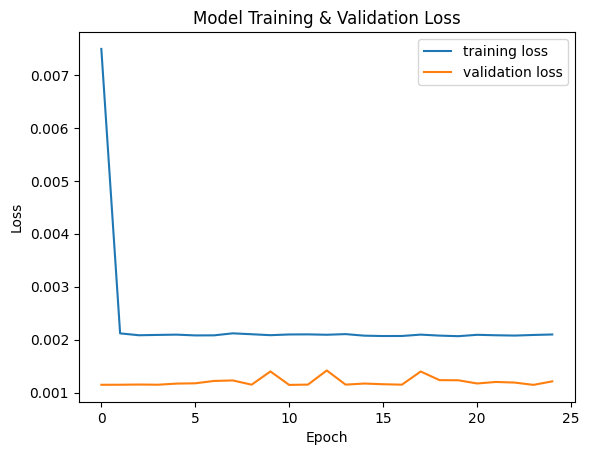

36/36 [==============================] - 1s 7ms/step


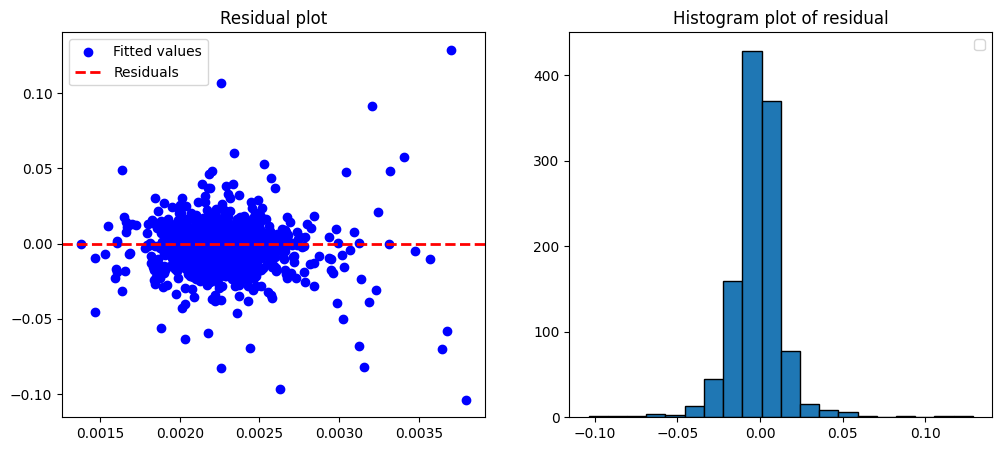

<Figure size 512x384 with 0 Axes>


   Training <keras.src.losses.Huber object at 0x7cdf3ee608e0> Loss    Validation <keras.src.losses.Huber object at 0x7cdf3ee608e0> Loss    Training RMSE    Training MAE    Training MAPE    Validation RMSE    Validation MAE    Validation MAPE
-----------------------------------------------------------------  -------------------------------------------------------------------  ---------------  --------------  ---------------  -----------------  ----------------  -----------------
                                                        0.0020969                                                           0.00121104        0.0647595       0.0452502          95896.2          0.0492146         0.0374157            9.45867 




In [11]:
model_lstm3 = Sequential()
model_lstm3.add(LSTM(50, activation='tanh',input_shape=(look_back, 1)))
model_lstm3.add(Dense(1, activation='tanh'))

# Compile the model
model_lstm3.compile(optimizer='adam', loss=Huber(delta=1.0), metrics=[RootMeanSquaredError(),MeanAbsoluteError(),MeanAbsolutePercentageError()])

# Train the model
lstm3_stats, lstm3_predictions= train(model=model_lstm3,
                                    X_train=X_train,
                                    y_train=y_train,
                                    X_test=X_test,
                                    y_test=y_test,
                                    epochs=25,
                                    batch_size=32,
                                    shuffle=True,
                                    validation_split = 0.1)

#LTSM with dropout

###Mean Absolute Error

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 50)                10400     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
131/131 [==============================] - 5s 19ms/step - loss: 0.0876 - root_mean_squared_error: 0.1270 - mean_absolute_error: 0.0876 - mean_absolute_percentage_error: 42368.2578 - val_loss: 0.0365 - val_root_mean_squared_error: 0.0481 - val_mean_absolute_error: 0.

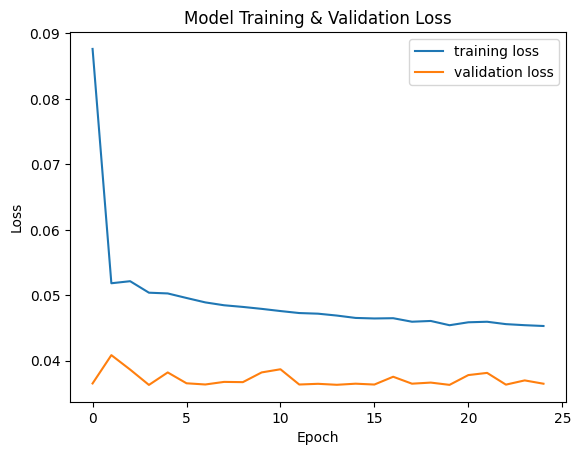

36/36 [==============================] - 1s 8ms/step


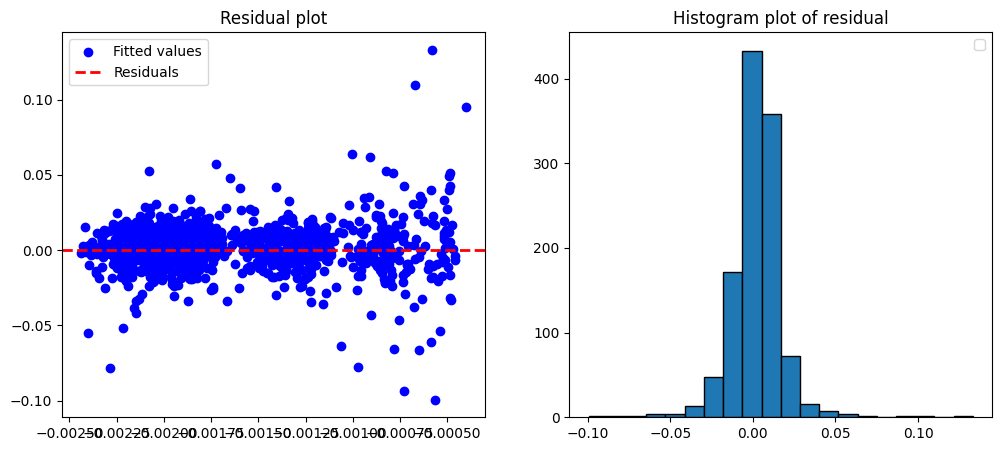

<Figure size 512x384 with 0 Axes>


   Training mean_absolute_error Loss    Validation mean_absolute_error Loss    Training RMSE    Training MAE    Training MAPE    Validation RMSE    Validation MAE    Validation MAPE
-----------------------------------  -------------------------------------  ---------------  --------------  ---------------  -----------------  ----------------  -----------------
                          0.0453143                              0.0364973        0.0648248       0.0453143          98036.5          0.0480249         0.0364973            8.91413 




In [12]:
# Create the model
model_lstm_with_dropout1 = Sequential()
model_lstm_with_dropout1.add(LSTM(50, activation='tanh', input_shape=(look_back, 1)))
model_lstm_with_dropout1.add(Dropout(0.2))
model_lstm_with_dropout1.add(Dense(1, activation='tanh'))

# Compile the model
model_lstm_with_dropout1.compile(optimizer='adam',loss='mean_absolute_error', metrics=[RootMeanSquaredError(), MeanAbsoluteError(), MeanAbsolutePercentageError()])

# Train the model
lstm_with_dropout_stats1, lstm_with_dropout_predictions1 = train(model=model_lstm_with_dropout1,
                                                              X_train=X_train,
                                                              y_train=y_train,
                                                              X_test=X_test,
                                                              y_test=y_test,
                                                              epochs=25,
                                                              batch_size=32,
                                                              shuffle=True,
                                                              validation_split=0.1)


###Mean Absolute Percentage Error

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 50)                10400     
                                                                 
 dropout_4 (Dropout)         (None, 50)                0         
                                                                 
 dense_10 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
131/131 [==============================] - 5s 21ms/step - loss: 67646.4688 - root_mean_squared_error: 0.1960 - mean_absolute_error: 0.1672 - mean_absolute_percentage_error: 67646.4688 - val_loss: 10.8466 - val_root_mean_squared_error: 0.0608 - val_mean_absolute_err

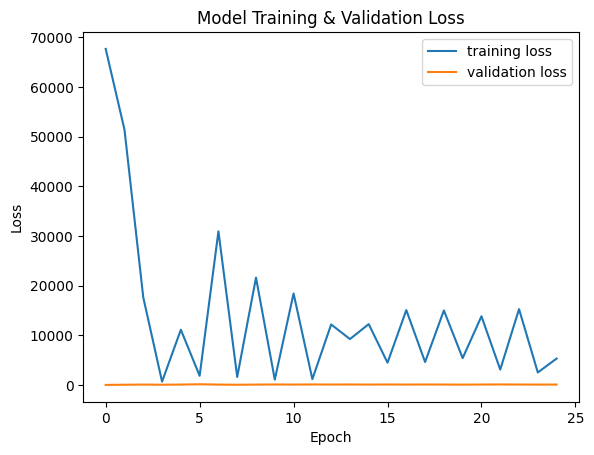

36/36 [==============================] - 1s 6ms/step


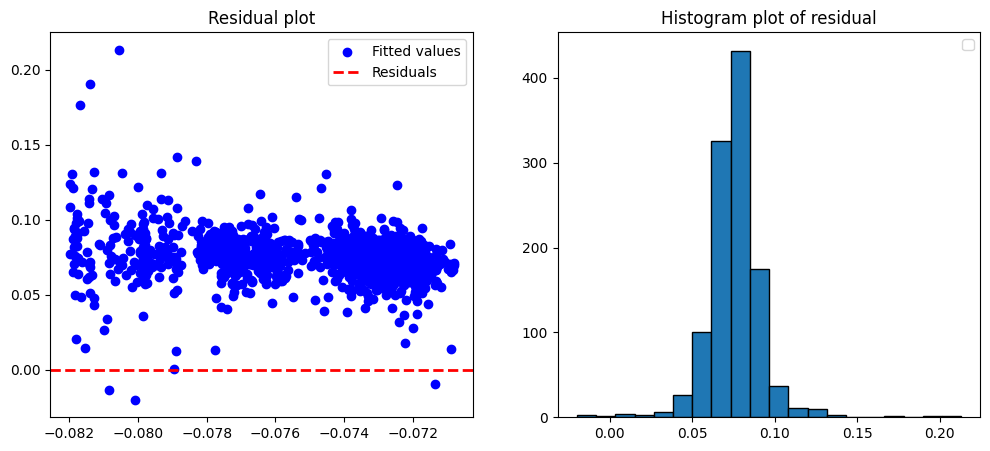

<Figure size 512x384 with 0 Axes>


   Training mean_absolute_percentage_error Loss    Validation mean_absolute_percentage_error Loss    Training RMSE    Training MAE    Training MAPE    Validation RMSE    Validation MAE    Validation MAPE
----------------------------------------------  ------------------------------------------------  ---------------  --------------  ---------------  -----------------  ----------------  -----------------
                                       5316.97                                           86.1712         0.372728        0.366062          5316.97           0.366038          0.362812            86.1712 




In [13]:
# Create the model
model_lstm_with_dropout2 = Sequential()
model_lstm_with_dropout2.add(LSTM(50, activation='tanh', input_shape=(look_back, 1)))
model_lstm_with_dropout2.add(Dropout(0.2))
model_lstm_with_dropout2.add(Dense(1, activation='tanh'))

# Compile the model
model_lstm_with_dropout2.compile(optimizer='adam',loss='mean_absolute_percentage_error', metrics=[RootMeanSquaredError(), MeanAbsoluteError(), MeanAbsolutePercentageError()])

# Train the model
lstm_with_dropout_stats2, lstm_with_dropout_predictions2 = train(model=model_lstm_with_dropout2,
                                                              X_train=X_train,
                                                              y_train=y_train,
                                                              X_test=X_test,
                                                              y_test=y_test,
                                                              epochs=25,
                                                              batch_size=32,
                                                              shuffle=True,
                                                              validation_split=0.1)


### Huber

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 50)                10400     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
131/131 [==============================] - 7s 25ms/step - loss: 0.0089 - root_mean_squared_error: 0.1333 - mean_absolute_error: 0.0946 - mean_absolute_percentage_error: 2046.0957 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0482 - val_mean_absolute_error: 0.

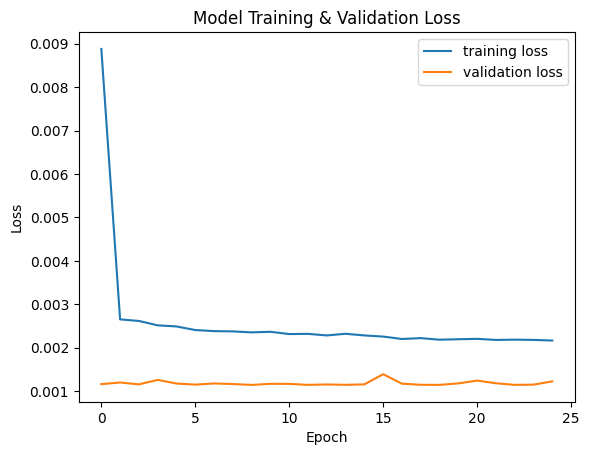

36/36 [==============================] - 1s 5ms/step


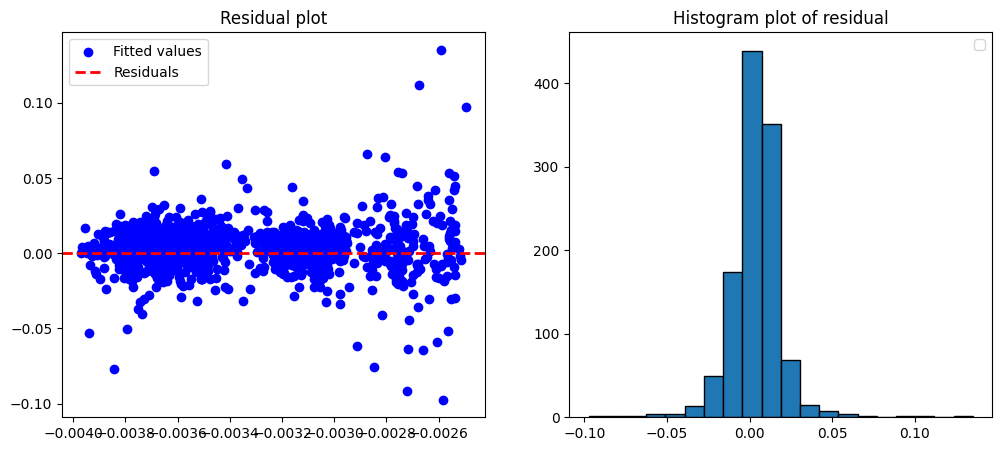

<Figure size 512x384 with 0 Axes>


   Training <keras.src.losses.Huber object at 0x7cdf29358310> Loss    Validation <keras.src.losses.Huber object at 0x7cdf29358310> Loss    Training RMSE    Training MAE    Training MAPE    Validation RMSE    Validation MAE    Validation MAPE
-----------------------------------------------------------------  -------------------------------------------------------------------  ---------------  --------------  ---------------  -----------------  ----------------  -----------------
                                                       0.00216716                                                            0.0012259        0.0658355       0.0466224           104828          0.0495157         0.0380201            9.09563 




In [14]:
# Create the model
model_lstm_with_dropout3 = Sequential()
model_lstm_with_dropout3.add(LSTM(50, activation='tanh', input_shape=(look_back, 1)))
model_lstm_with_dropout3.add(Dropout(0.2))
model_lstm_with_dropout3.add(Dense(1, activation='tanh'))

# Compile the model
model_lstm_with_dropout3.compile(optimizer='adam',loss=Huber(delta=1.0), metrics=[RootMeanSquaredError(), MeanAbsoluteError(), MeanAbsolutePercentageError()])

# Train the model
lstm_with_dropout_stats3, lstm_with_dropout_predictions3 = train(model=model_lstm_with_dropout3,
                                                              X_train=X_train,
                                                              y_train=y_train,
                                                              X_test=X_test,
                                                              y_test=y_test,
                                                              epochs=25,
                                                              batch_size=32,
                                                              shuffle=True,
                                                              validation_split=0.1)


# GRU

### Mean Absolute Error

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 50)                7950      
                                                                 
 dense_12 (Dense)            (None, 1)                 51        
                                                                 
Total params: 8001 (31.25 KB)
Trainable params: 8001 (31.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
131/131 [==============================] - 5s 21ms/step - loss: 0.0877 - root_mean_squared_error: 0.1406 - mean_absolute_error: 0.0877 - mean_absolute_percentage_error: 74757.4375 - val_loss: 0.0363 - val_root_mean_squared_error: 0.0479 - val_mean_absolute_error: 0.0363 - val_mean_absolute_percentage_error: 8.8781
Epoch 2/25
131/131 [==============================] - 3s 23ms/step - loss: 0.0454 -

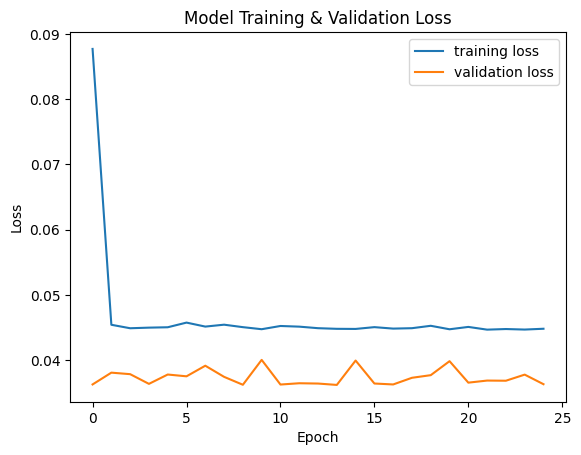

36/36 [==============================] - 1s 5ms/step


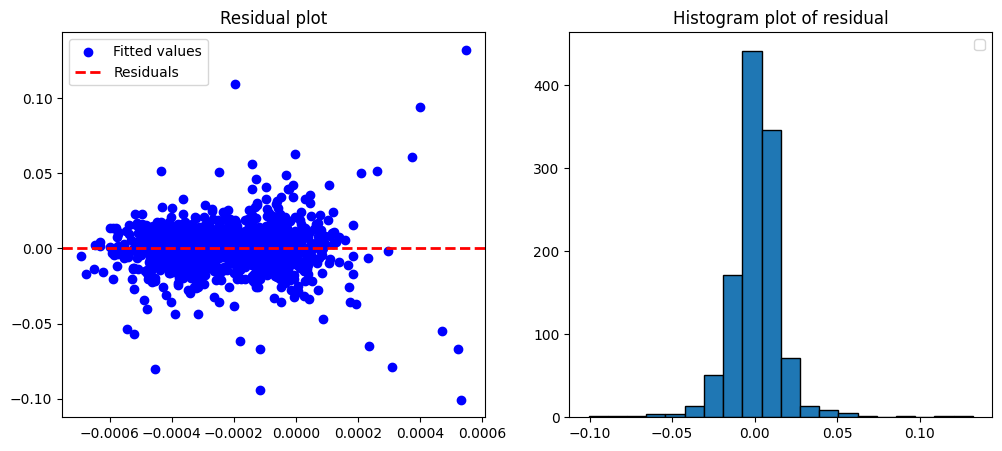

<Figure size 512x384 with 0 Axes>


   Training mean_absolute_error Loss    Validation mean_absolute_error Loss    Training RMSE    Training MAE    Training MAPE    Validation RMSE    Validation MAE    Validation MAPE
-----------------------------------  -------------------------------------  ---------------  --------------  ---------------  -----------------  ----------------  -----------------
                          0.0448399                              0.0363486        0.0643589       0.0448399          99720.5          0.0478959         0.0363486            8.97779 




In [15]:
model_gru1 = Sequential()
model_gru1.add(GRU(50, activation='tanh',input_shape=(look_back, 1)))
model_gru1.add(Dense(1, activation='tanh'))

# Compile the model
model_gru1.compile(optimizer='adam', loss='mean_absolute_error', metrics=[RootMeanSquaredError(),MeanAbsoluteError(),MeanAbsolutePercentageError()])

# Train the model
gru1_stats, gru1_predictions= train(model=model_gru1,
                                    X_train=X_train,
                                    y_train=y_train,
                                    X_test=X_test,
                                    y_test=y_test,
                                    epochs=25,
                                    batch_size=32,
                                    shuffle=True,
                                    validation_split = 0.1)

### Mean Absolute Percentage Error

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 50)                7950      
                                                                 
 dense_13 (Dense)            (None, 1)                 51        
                                                                 
Total params: 8001 (31.25 KB)
Trainable params: 8001 (31.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
131/131 [==============================] - 5s 23ms/step - loss: 99173.4453 - root_mean_squared_error: 0.1351 - mean_absolute_error: 0.0959 - mean_absolute_percentage_error: 99173.4453 - val_loss: 55.8072 - val_root_mean_squared_error: 0.2417 - val_mean_absolute_error: 0.2369 - val_mean_absolute_percentage_error: 55.8072
Epoch 2/25
131/131 [==============================] - 3s 23ms/step - loss: 46

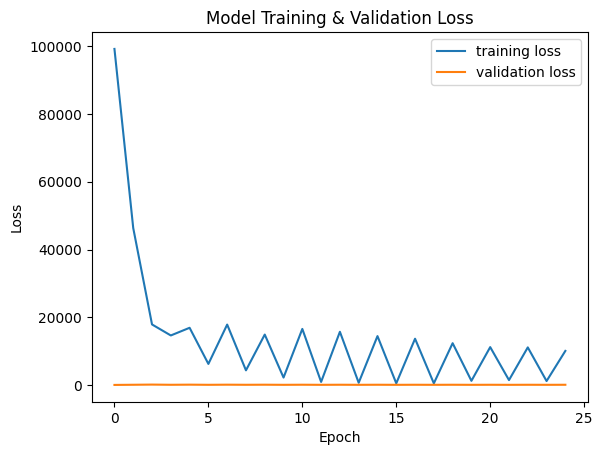

36/36 [==============================] - 1s 8ms/step


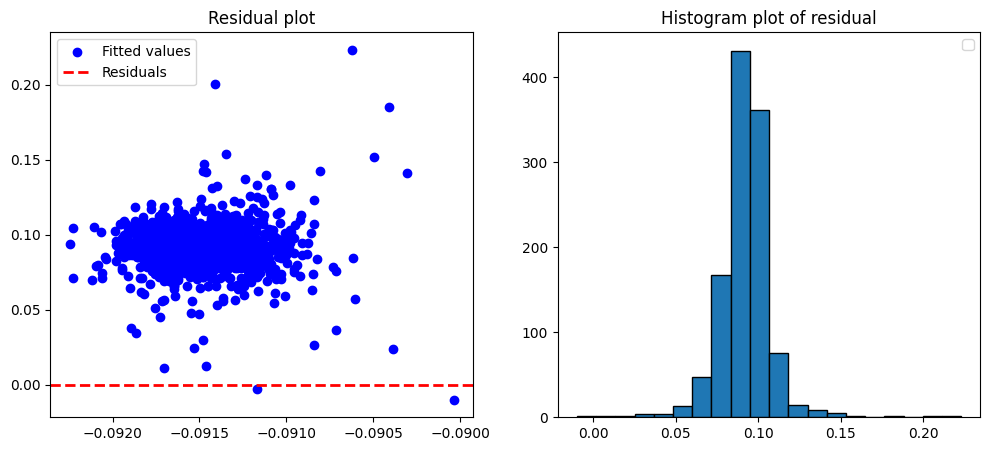

<Figure size 512x384 with 0 Axes>


   Training mean_absolute_percentage_error Loss    Validation mean_absolute_percentage_error Loss    Training RMSE    Training MAE    Training MAPE    Validation RMSE    Validation MAE    Validation MAPE
----------------------------------------------  ------------------------------------------------  ---------------  --------------  ---------------  -----------------  ----------------  -----------------
                                       10091.4                                            100.38         0.399362        0.393688          10091.4           0.424355          0.421647             100.38 




In [16]:
model_gru2 = Sequential()
model_gru2.add(GRU(50, activation='tanh',input_shape=(look_back, 1)))
model_gru2.add(Dense(1, activation='tanh'))

# Compile the model
model_gru2.compile(optimizer='adam', loss='mean_absolute_percentage_error', metrics=[RootMeanSquaredError(),MeanAbsoluteError(),MeanAbsolutePercentageError()])

# Train the model
gru2_stats, gru2_predictions= train(model=model_gru2,
                                    X_train=X_train,
                                    y_train=y_train,
                                    X_test=X_test,
                                    y_test=y_test,
                                    epochs=25,
                                    batch_size=32,
                                    shuffle=True,
                                    validation_split = 0.1)

### Huber

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 50)                10400     
                                                                 
 dense_14 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
131/131 [==============================] - 5s 22ms/step - loss: 0.0086 - root_mean_squared_error: 0.1311 - mean_absolute_error: 0.0894 - mean_absolute_percentage_error: 62927.1719 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0482 - val_mean_absolute_error: 0.0367 - val_mean_absolute_percentage_error: 8.9250
Epoch 2/25
131/131 [==============================] - 2s 17ms/step - loss: 0.0021

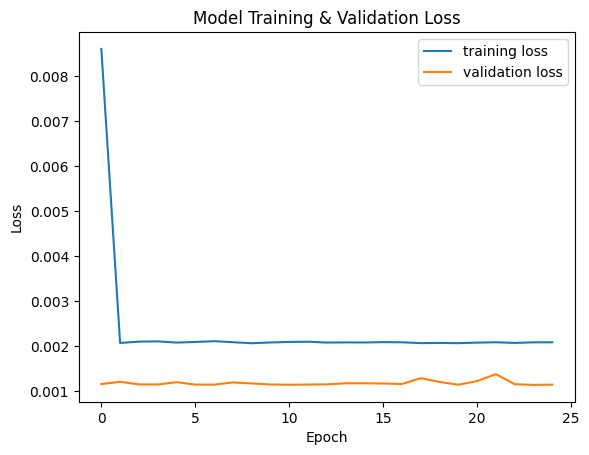

36/36 [==============================] - 1s 5ms/step


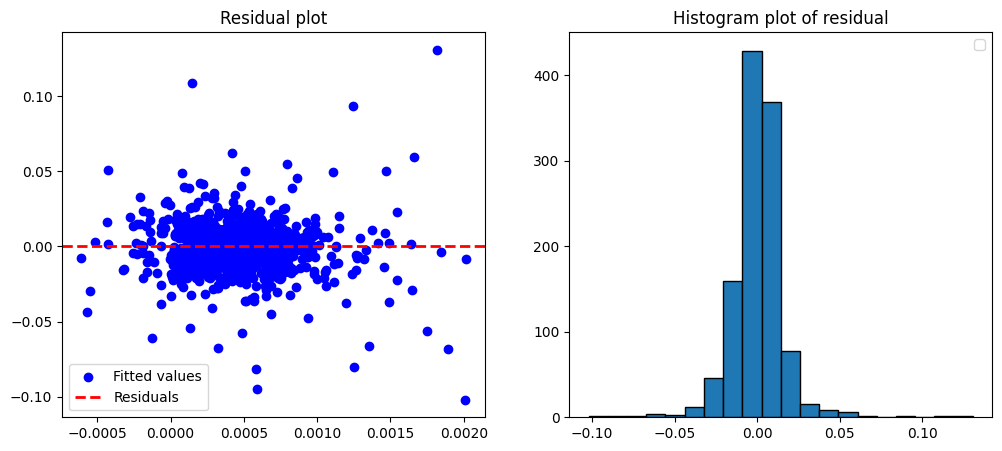

<Figure size 512x384 with 0 Axes>


   Training <keras.src.losses.Huber object at 0x7cdf26ed44f0> Loss    Validation <keras.src.losses.Huber object at 0x7cdf26ed44f0> Loss    Training RMSE    Training MAE    Training MAPE    Validation RMSE    Validation MAE    Validation MAPE
-----------------------------------------------------------------  -------------------------------------------------------------------  ---------------  --------------  ---------------  -----------------  ----------------  -----------------
                                                       0.00208912                                                           0.00114967        0.0646393       0.0452805           101188          0.0479515         0.0363811            9.02684 




In [17]:
model_gru3 = Sequential()
model_gru3.add(LSTM(50, activation='tanh',input_shape=(look_back, 1)))
model_gru3.add(Dense(1, activation='tanh'))

# Compile the model
model_gru3.compile(optimizer='adam', loss=Huber(delta=1.0), metrics=[RootMeanSquaredError(),MeanAbsoluteError(),MeanAbsolutePercentageError()])

# Train the model
gru3_stats, gru3_predictions= train(model=model_gru3,
                                    X_train=X_train,
                                    y_train=y_train,
                                    X_test=X_test,
                                    y_test=y_test,
                                    epochs=25,
                                    batch_size=32,
                                    shuffle=True,
                                    validation_split = 0.1)

#GRU with dropout

###Mean Absolute Error

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 50)                7950      
                                                                 
 dropout_6 (Dropout)         (None, 50)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                 51        
                                                                 
Total params: 8001 (31.25 KB)
Trainable params: 8001 (31.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
131/131 [==============================] - 5s 22ms/step - loss: 0.0868 - root_mean_squared_error: 0.1286 - mean_absolute_error: 0.0868 - mean_absolute_percentage_error: 105278.1406 - val_loss: 0.0372 - val_root_mean_squared_error: 0.0489 - val_mean_absolute_error: 0.

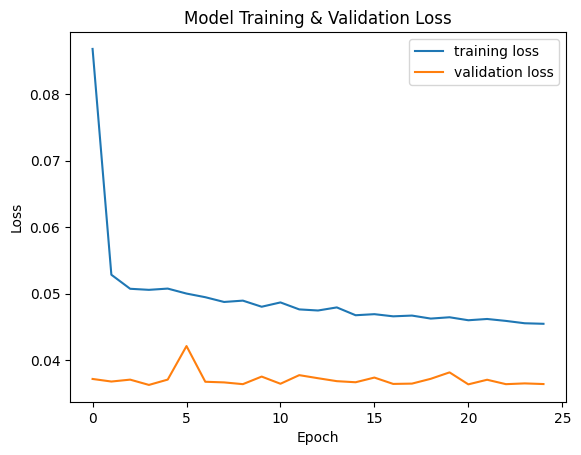

36/36 [==============================] - 1s 5ms/step


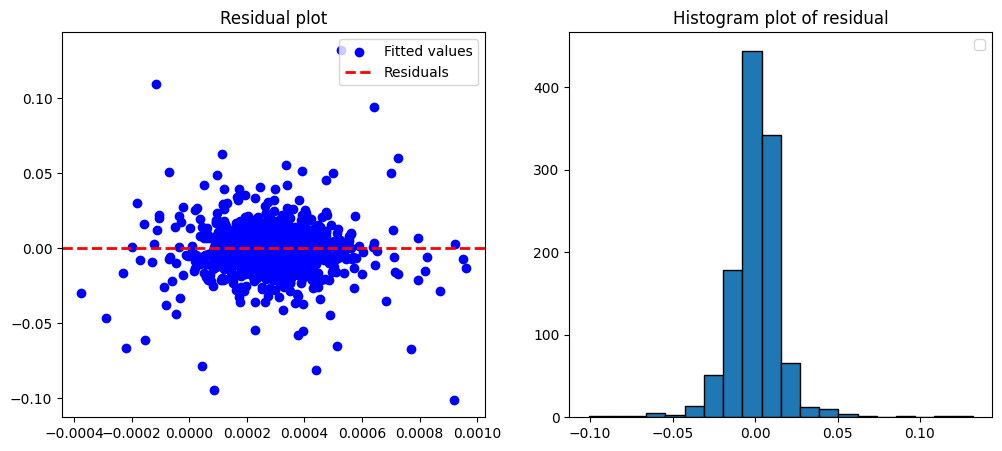

<Figure size 512x384 with 0 Axes>


   Training mean_absolute_error Loss    Validation mean_absolute_error Loss    Training RMSE    Training MAE    Training MAPE    Validation RMSE    Validation MAE    Validation MAPE
-----------------------------------  -------------------------------------  ---------------  --------------  ---------------  -----------------  ----------------  -----------------
                          0.0454628                              0.0363969        0.0649779       0.0454628           102234          0.0479428         0.0363969            9.01175 




In [18]:
# Create the model with MAE loss and Dropout
model_gru_with_dropout1 = Sequential()
model_gru_with_dropout1.add(GRU(50, activation='tanh', input_shape=(look_back, 1)))
model_gru_with_dropout1.add(Dropout(0.2))  # Add Dropout layer
model_gru_with_dropout1.add(Dense(1, activation='tanh'))

# Compile the model with MAE loss
model_gru_with_dropout1.compile(optimizer='adam', loss='mean_absolute_error', metrics=[RootMeanSquaredError(), MeanAbsoluteError(), MeanAbsolutePercentageError()])

# Train the model
gru_with_dropout_stats1, gru_with_dropout_predictions1 = train(model=model_gru_with_dropout1,
                                                          X_train=X_train,
                                                          y_train=y_train,
                                                          X_test=X_test,
                                                          y_test=y_test,
                                                          epochs=25,
                                                          batch_size=32,
                                                          shuffle=True,
                                                          validation_split=0.1)


###Mean Absolute Percentage Error

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 50)                7950      
                                                                 
 dropout_7 (Dropout)         (None, 50)                0         
                                                                 
 dense_16 (Dense)            (None, 1)                 51        
                                                                 
Total params: 8001 (31.25 KB)
Trainable params: 8001 (31.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
131/131 [==============================] - 5s 20ms/step - loss: 82460.6250 - root_mean_squared_error: 0.1571 - mean_absolute_error: 0.1301 - mean_absolute_percentage_error: 82460.6250 - val_loss: 15.3499 - val_root_mean_squared_error: 0.0796 - val_mean_absolute_error

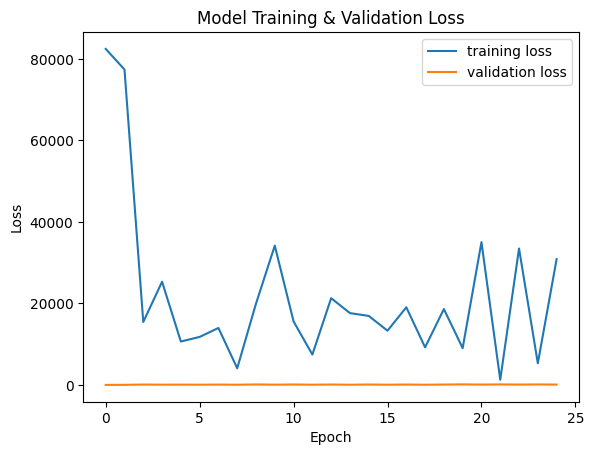

36/36 [==============================] - 1s 6ms/step


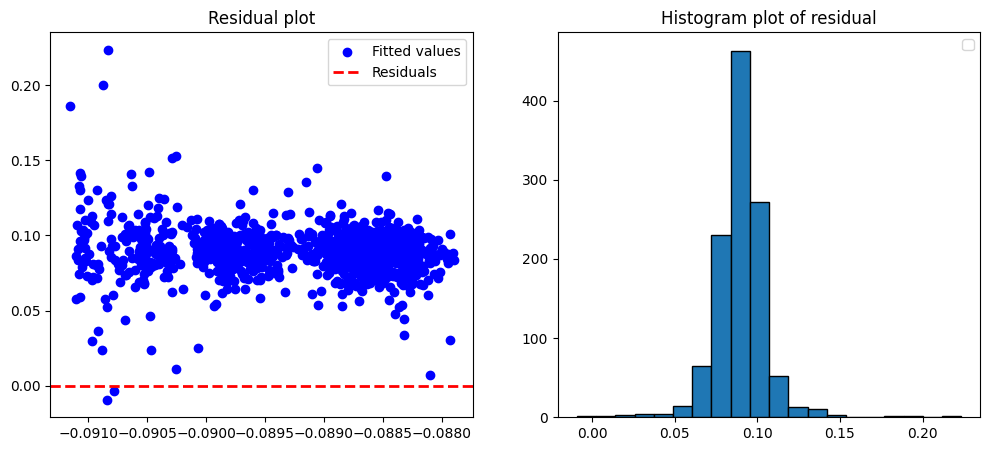

<Figure size 512x384 with 0 Axes>


   Training mean_absolute_percentage_error Loss    Validation mean_absolute_percentage_error Loss    Training RMSE    Training MAE    Training MAPE    Validation RMSE    Validation MAE    Validation MAPE
----------------------------------------------  ------------------------------------------------  ---------------  --------------  ---------------  -----------------  ----------------  -----------------
                                       30870.7                                           99.1939         0.510817        0.501995          30870.7           0.419508          0.416748            99.1939 




In [19]:
# Create the model with MAPE loss and Dropout
model_gru_with_dropout2 = Sequential()
model_gru_with_dropout2.add(GRU(50, activation='tanh', input_shape=(look_back, 1)))
model_gru_with_dropout2.add(Dropout(0.2))  # Add Dropout layer
model_gru_with_dropout2.add(Dense(1, activation='tanh'))

# Compile the model with MAPE loss
model_gru_with_dropout2.compile(optimizer='adam', loss='mean_absolute_percentage_error', metrics=[RootMeanSquaredError(), MeanAbsoluteError(), MeanAbsolutePercentageError()])

# Train the model
gru_with_dropout_stats2, gru_with_dropout_predictions2 = train(model=model_gru_with_dropout2,
                                                            X_train=X_train,
                                                            y_train=y_train,
                                                            X_test=X_test,
                                                            y_test=y_test,
                                                            epochs=25,
                                                            batch_size=32,
                                                            shuffle=True,
                                                            validation_split=0.1)


### Huber

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 50)                7950      
                                                                 
 dropout_8 (Dropout)         (None, 50)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                 51        
                                                                 
Total params: 8001 (31.25 KB)
Trainable params: 8001 (31.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
131/131 [==============================] - 5s 22ms/step - loss: 0.0073 - root_mean_squared_error: 0.1204 - mean_absolute_error: 0.0867 - mean_absolute_percentage_error: 104374.0781 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0479 - val_mean_absolute_error: 0.

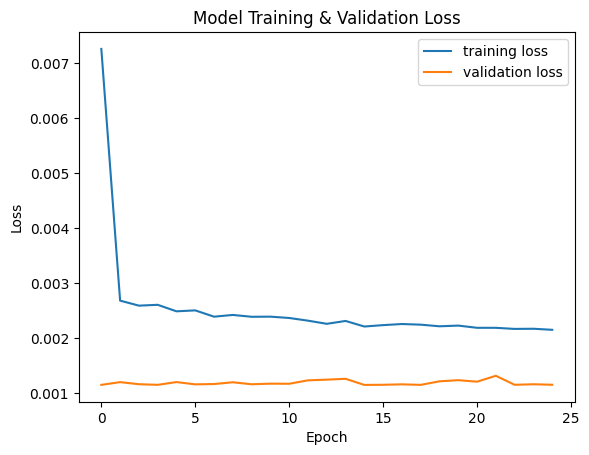

36/36 [==============================] - 1s 6ms/step


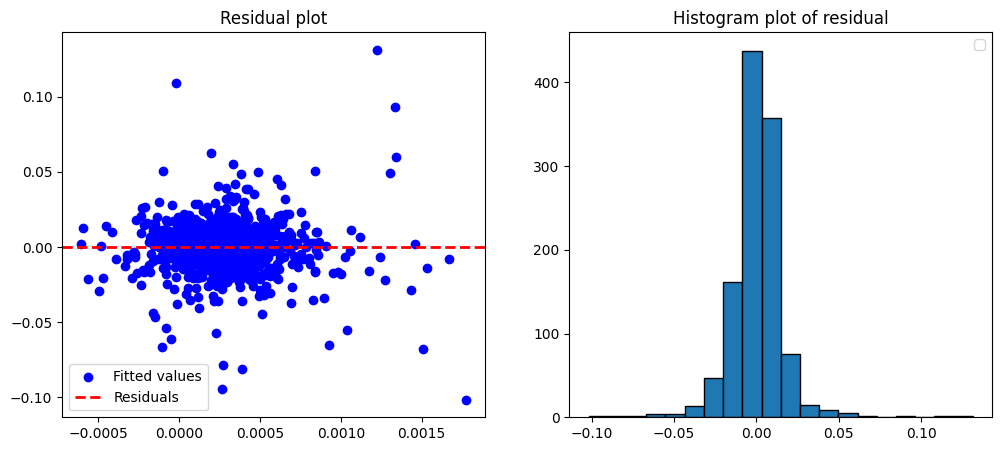

<Figure size 512x384 with 0 Axes>


   Training <keras.src.losses.Huber object at 0x7cdf1bfa3340> Loss    Validation <keras.src.losses.Huber object at 0x7cdf1bfa3340> Loss    Training RMSE    Training MAE    Training MAPE    Validation RMSE    Validation MAE    Validation MAPE
-----------------------------------------------------------------  -------------------------------------------------------------------  ---------------  --------------  ---------------  -----------------  ----------------  -----------------
                                                       0.00214697                                                            0.0011481        0.0655282       0.0461141          97673.6          0.0479186         0.0363541            9.01194 




In [20]:
# Create the model with Huber loss and Dropout
model_gru_with_dropout3 = Sequential()
model_gru_with_dropout3.add(GRU(50, activation='tanh', input_shape=(look_back, 1)))
model_gru_with_dropout3.add(Dropout(0.2))  # Add Dropout layer
model_gru_with_dropout3.add(Dense(1, activation='tanh'))

# Compile the model with Huber loss
model_gru_with_dropout3.compile(optimizer='adam', loss=Huber(delta=1.0), metrics=[RootMeanSquaredError(), MeanAbsoluteError(), MeanAbsolutePercentageError()])

# Train the model
gru_with_dropout_stats3, gru_with_dropout_predictions3 = train(model=model_gru_with_dropout3,
                                                              X_train=X_train,
                                                              y_train=y_train,
                                                              X_test=X_test,
                                                              y_test=y_test,
                                                              epochs=25,
                                                              batch_size=32,
                                                              shuffle=True,
                                                              validation_split=0.1)
